#**Sarcasm Detection using Multi Channel CNN In News Headlines**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, f1_score
from keras import models, layers, optimizers, losses, callbacks
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import zipfile

In [2]:
zip=zipfile.ZipFile('archive (4).zip')
zip.extractall()

**Processing Data**

In [3]:
df1=pd.read_json('Sarcasm_Headlines_Dataset.json',lines = True)
df2=pd.read_json('Sarcasm_Headlines_Dataset_v2.json',lines = True)

In [4]:
df1

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [5]:
df2

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [6]:
frames=[df1,df2]
df=pd.concat(frames)

In [7]:
df.reset_index(drop=True, inplace=True)
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
55323,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
55324,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
55325,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
55326,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg-gat...,1


In [8]:
df.iloc[-1,:].values

array(['https://www.theonion.com/dad-clarifies-this-not-a-food-stop-1819576557',
       'dad clarifies this not a food stop', 1], dtype=object)

In [9]:
df['is_sarcastic'].value_counts()

0    29970
1    25358
Name: is_sarcastic, dtype: int64

**Data preprocessing**

In [10]:
# Remove html tags
def removeHTML(sentence):
    regex = re.compile('<.*?>')
    return re.sub(regex, ' ', sentence)

# Remove URLs
def removeURL(sentence):
    regex = re.compile('http[s]?://\S+')
    return re.sub(regex, ' ', sentence)

# remove numbers, punctuation and any special characters (keep only alphabets)
def onlyAlphabets(sentence):
    regex = re.compile('[^a-zA-Z]')
    return re.sub(regex, ' ', sentence)

In [11]:
sno = nltk.stem.SnowballStemmer('english')    # Initializing stemmer
wordcloud = [[], []]
all_sentences = []    # All cleaned sentences


for x in range(len(df['headline'].values)):
    headline = df['headline'].values[x]
    sarcasm = df['is_sarcastic'].values[x]

    cleaned_sentence = []
    sentence = removeURL(headline) 
    sentence = removeHTML(sentence)
    sentence = onlyAlphabets(sentence)
    sentence = sentence.lower()   

    for word in sentence.split():
        #if word not in stop:
            stemmed = sno.stem(word)
            cleaned_sentence.append(stemmed)
            
            wordcloud[sarcasm].append(word)
            

    all_sentences.append(' '.join(cleaned_sentence))

# add as column in dataframe
X = all_sentences
y = df['is_sarcastic']

In [12]:
class_names = ['Not sarcastic', 'Sarcastic']

**Word cloud**

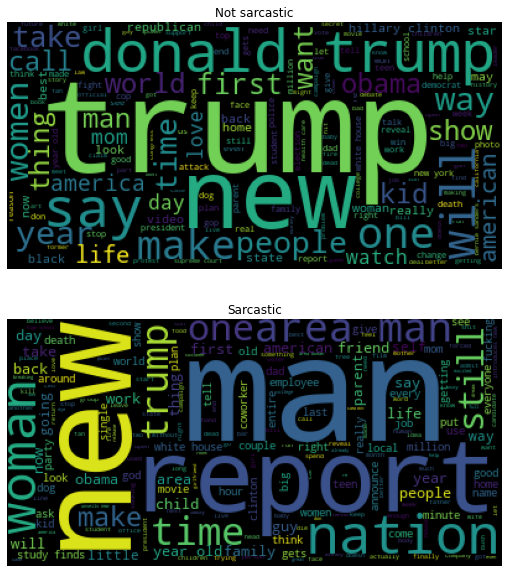

In [13]:
plt.figure(figsize=(10,10))

for i in range(len(class_names)):
    ax = plt.subplot(len(class_names), 1, i + 1)
    plt.imshow(WordCloud().generate(' '.join(wordcloud[i])))
    plt.title(class_names[i])
    plt.axis("off")

**Data split**

In [14]:
# Splitting into train and val set -- 80-20 split

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2)

In [15]:
# Tokenization
vocab = 1500
mlen = 200
 
tokenizer = Tokenizer(num_words = vocab, oov_token = '<UNK>')
tokenizer.fit_on_texts(Xtrain)
 
Xtrain = tokenizer.texts_to_sequences(Xtrain)
Xtrain = pad_sequences(Xtrain, maxlen=mlen)

Xval = tokenizer.texts_to_sequences(Xval)
Xval = pad_sequences(Xval, maxlen=mlen)

In [16]:
Xtrain.shape

(44262, 200)

In [17]:
Xval.shape

(11066, 200)

**Multi channel Model using CNN Construction and Evaluation**

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     150000      input_1[0][0]                    
______________________________________________________________________________________________

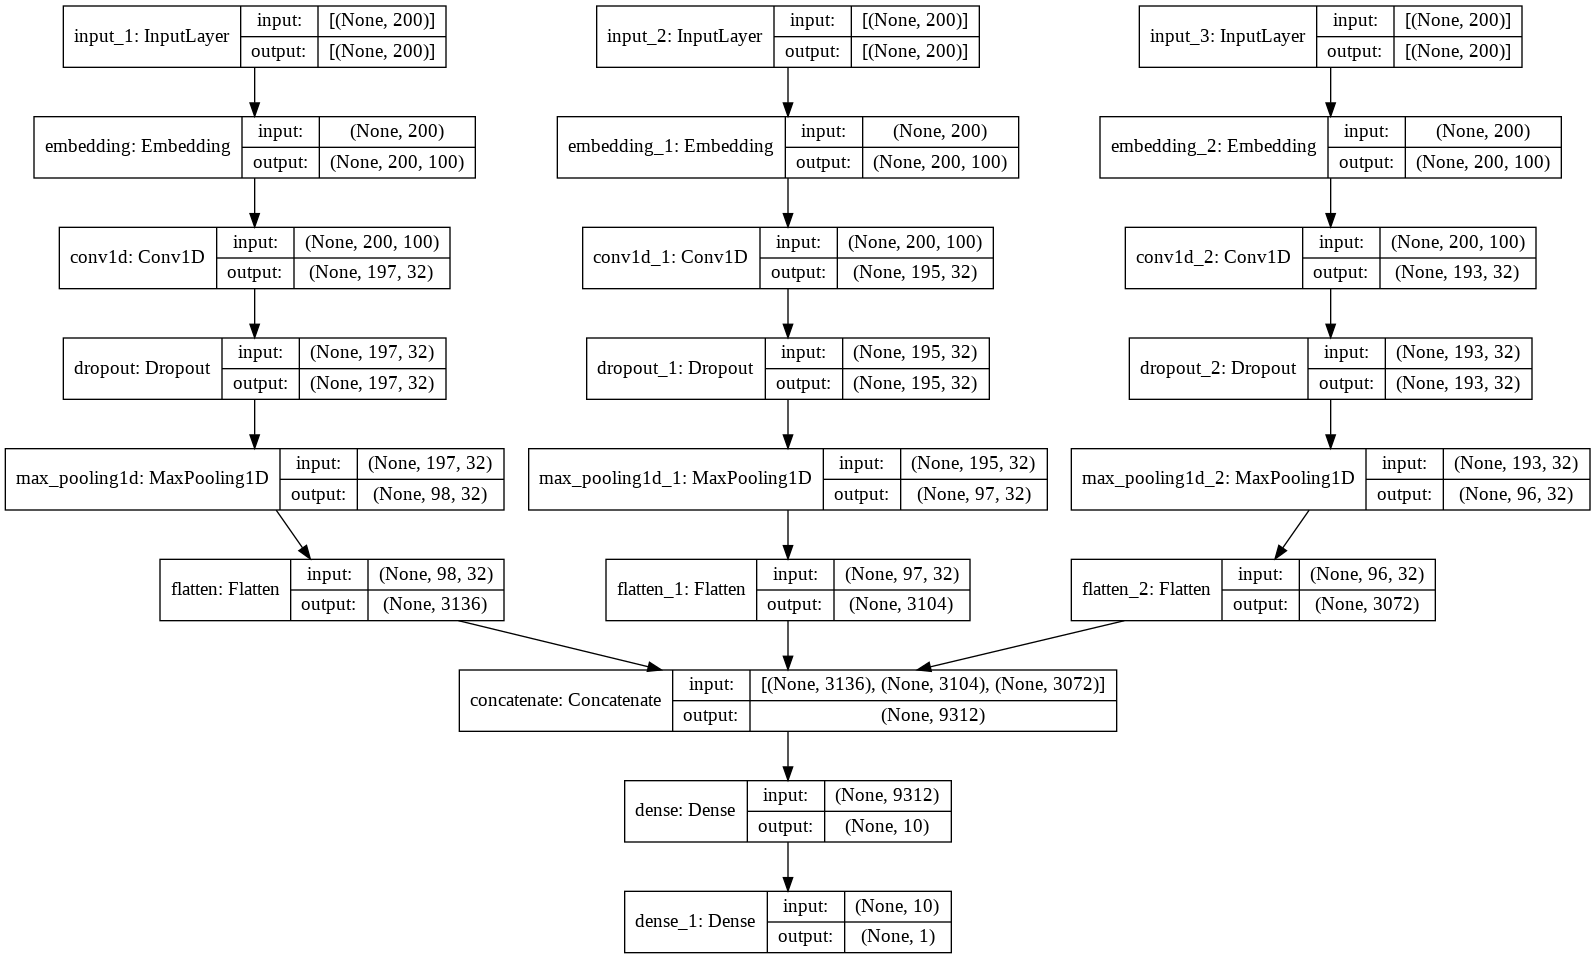

In [18]:
#channel 1
inputs1 = Input(shape=(mlen,))
embedding1 = Embedding(vocab, 100)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
# channel 2
inputs2 = Input(shape=(mlen,))
embedding2 = Embedding(vocab, 100)(inputs2)
conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)
# channel 3
inputs3 = Input(shape=(mlen,))
embedding3 = Embedding(vocab, 100)(inputs3)
conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
dense1 = Dense(10, activation='relu')(merged)
outputs = Dense(1, activation='sigmoid')(dense1)
model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
model.summary()
plot_model(model, show_shapes=True, to_file='multichannel.png')

In [20]:
history=model.fit([Xtrain,Xtrain,Xtrain], ytrain, epochs=25, batch_size=2500,validation_data=([Xval,Xval,Xval],yval))
model.save('SDNH.h5')

Epoch 1/25
18/18 [==============================] - 137s 8s/step - loss: 0.4350 - accuracy: 0.8665 - val_loss: 0.4617 - val_accuracy: 0.8541
Epoch 2/25
18/18 [==============================] - 137s 8s/step - loss: 0.4256 - accuracy: 0.8718 - val_loss: 0.4531 - val_accuracy: 0.8562
Epoch 3/25
18/18 [==============================] - 139s 8s/step - loss: 0.4159 - accuracy: 0.8771 - val_loss: 0.4476 - val_accuracy: 0.8574
Epoch 4/25
18/18 [==============================] - 137s 8s/step - loss: 0.4066 - accuracy: 0.8815 - val_loss: 0.4414 - val_accuracy: 0.8606
Epoch 5/25
18/18 [==============================] - 136s 8s/step - loss: 0.3971 - accuracy: 0.8876 - val_loss: 0.4352 - val_accuracy: 0.8667
Epoch 6/25
18/18 [==============================] - 136s 8s/step - loss: 0.3882 - accuracy: 0.8906 - val_loss: 0.4294 - val_accuracy: 0.8687
Epoch 7/25
18/18 [==============================] - 137s 8s/step - loss: 0.3800 - accuracy: 0.8942 - val_loss: 0.4228 - val_accuracy: 0.8715
Epoch 8/25
18

In [21]:
model.evaluate([Xval,Xval,Xval] ,yval)

346/346 [==============================] - 9s 27ms/step - loss: 0.2457 - accuracy: 0.9367


[0.24573823809623718, 0.9367431998252869]

**Confusion Matrix**

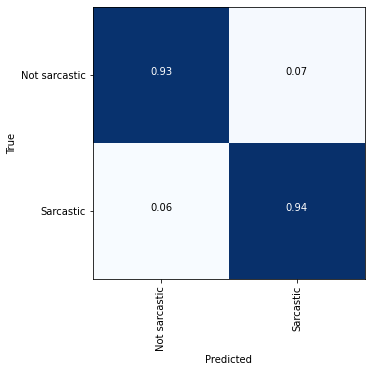

In [22]:
cm = confusion_matrix(yval, (model.predict([Xval,Xval,Xval])>0.5).astype('int64'))
cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        if cm[i,j] > 0.8:
            clr = "white"
        else:
            clr = "black"
        ax.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color=clr)

_ = ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation = 90)
ax.set_yticklabels(class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Plotting Accuracy and Loss**

In [23]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.legend([variable, variable2])
    plt.title(variable)

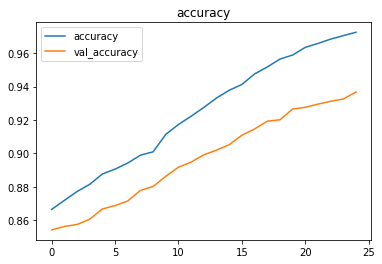

In [24]:
plot(history.history, "accuracy", 'val_accuracy')

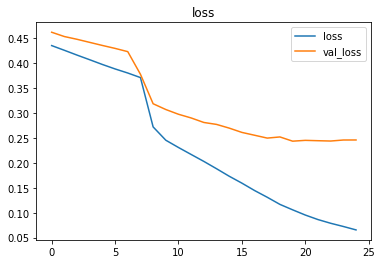

In [25]:
plot(history.history, "loss", 'val_loss')

**Model prediction**

In [31]:
x = np.random.randint(0, Xval.shape[0] - 1)

headline = df['headline'].values[x]

print("Headline: ", headline)

cleaned_text = []

sentence = removeURL(headline) 
sentence = removeHTML(sentence)
sentence = onlyAlphabets(sentence)
sentence = sentence.lower()   

for word in sentence.split():
    #if word not in stop:
        stemmed = sno.stem(word)
        cleaned_text.append(stemmed)

cleaned_text = [' '.join(cleaned_text)]

print("Cleaned text: ", cleaned_text[0])

cleaned_text = tokenizer.texts_to_sequences(cleaned_text)
cleaned_text = pad_sequences(cleaned_text, maxlen=mlen)

category = df['is_sarcastic'].values[x]  

print("\nTrue category: ", class_names[category])
m=cleaned_text
output = model.predict([m,m,m])
pred=0
pred = int(np.round(output,0))
#print(pred)
print("\nPredicted category: ",class_names[pred],"(", output, "-->", pred, ")")

Headline:  hemmed-in seattle mayor calls for emergency deforestation
Cleaned text:  hem in seattl mayor call for emerg deforest

True category:  Sarcastic

Predicted category:  Sarcastic ( [[0.9680184]] --> 1 )
